In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [ ]:
def plot_decision_boundary2(model, title):
    # given a linear model plot the decision boundary using the weights of the linear layer
    w = model[0].weight.data.numpy()
    b = model[0].bias.data.numpy()
    x = np.linspace(-3, 3, 100)
    y = -w[0][0]/w[0][1] * x - b[0]/w[0][1]
    plt.plot(x, y, label=title)
    plt.legend()

def plot_opt_decision_boundary(w, gamma, p):
    # given a linear model plot the decision boundary using the weights of the linear layer
    x = np.linspace(-3, 3, 100)
    y = -w[0]/w[1] * x - np.log(p/(1-p))/w[1]
    plt.plot(x, y, label="Optimal Decision Boundary")
    plt.legend()

In [ ]:
def gen_data(n, d, w, gamma, p):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + gamma * (2*ys-1) * w
    return xs.float(), ys

In [ ]:
def bayes_accuracy(xs, ys, w, gamma, p):
    temp = 1/(1+torch.exp(2*gamma*torch.matmul(xs, w)))
    preds = temp <= p
    return (preds == ys[:,0]).float().mean()

In [ ]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xTrain))
        loss = F.binary_cross_entropy(outputs, yTrain)
        loss.backward()
        optimizer.step()
    return model

In [ ]:
def adapt(model, xTarget, epochs = 100000):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model(xTarget)

        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        loss = F.binary_cross_entropy(probsPred, labelPreds)

        # labelPreds = (outputs > 0).float().detach()
        # loss = torch.mean(torch.clamp(1 - outputs.t() * labelPreds, min=0))
        # loss = torch.mean(torch.exp(-outputs.t() * labelPreds))
        loss.backward()
        optimizer.step()
    return model

In [ ]:
def evaluate(model, x, y):
    return((model(x) > 0) == y).float().mean().item()

In [ ]:
n = 1000
d = 2
w = torch.ones(d)/np.sqrt(d)
gamma = 0.3
pSource = 0.5
pTarget = 0.9

In [ ]:
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

In [ ]:
bAccuSource = bayes_accuracy(xSourceTest, ySourceTest, w, gamma, pSource)
bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, pTarget)
print("Bayes accuracy on source is:", bAccuSource)
print("Bayes accuracy on target is:", bAccuTarget)

Bayes accuracy on source is: tensor(0.5880)
Bayes accuracy on target is: tensor(0.9080)


In [ ]:
# model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
# print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
# print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

model = adapt(model, xTargetTrain)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 100000/100000 [01:02<00:00, 1589.41it/s]

Accuracy on source is: 0.5820000171661377
Accuracy on target is: 0.8009999990463257


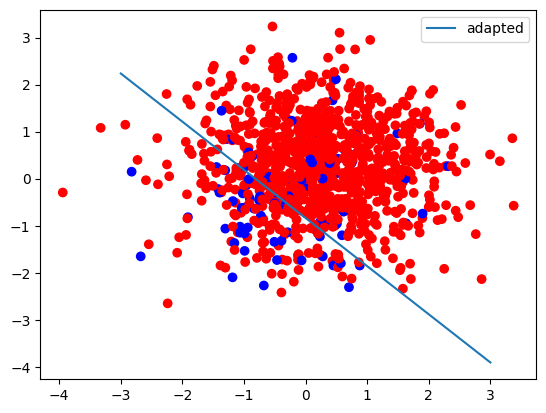

In [ ]:
# pot the target data and the initial and adapted decision boundaries
# plt.figure(figsize=(10,10))
plt.scatter(xTargetTest[:,0], xTargetTest[:,1], c=yTargetTest[:,0], cmap='bwr')
plot_decision_boundary2(model, 'adapted')
plt.show()

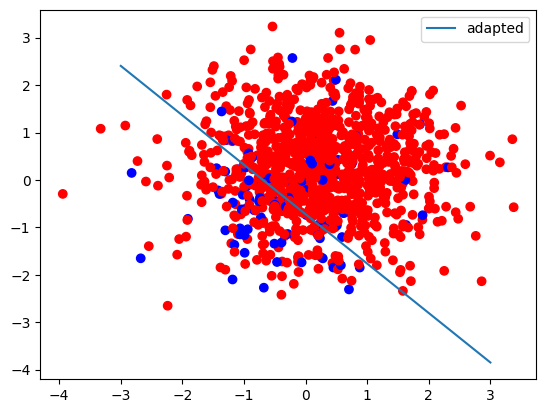

In [ ]:
# pot the target data and the initial and adapted decision boundaries
# plt.figure(figsize=(10,10))
plt.scatter(xTargetTest[:,0], xTargetTest[:,1], c=yTargetTest[:,0], cmap='bwr')
plot_decision_boundary2(model, 'adapted')
plt.show()

In [ ]:
import plotly
import plotly.graph_objs as go

def optiLandscape(xs):
    # compute the cross entropy loss for each point in the grid where the weight ranges from -2 to 2 and the bias ranges from -2 to 2
    # plot the loss as a function of the weight and bias
    # plot the decision boundary of the model with the lowest loss

    # obtain meshgrid of points
    w = np.linspace(-10, 10, 200)
    b = np.linspace(-10, 10, 200)
    ww, bb = np.meshgrid(w, b)
    # flatten the meshgrid and stack them together
    ww_flat = ww.flatten()
    bb_flat = bb.flatten()
    ww_flat = torch.tensor(ww_flat, dtype=torch.float32)
    bb_flat = torch.tensor(bb_flat, dtype=torch.float32)
    wb_flat = torch.stack([ww_flat, bb_flat], dim=1)
    # obtain predictions
    model = nn.Sequential(nn.Linear(1, 1))
    dic = collections.defaultdict(float)
    for w, b in wb_flat:
        model[0].weight.data = torch.tensor([[w]])
        model[0].bias.data = torch.tensor([b])
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(xs))
            pred = pred.squeeze()
            dic[(w, b)] = F.binary_cross_entropy(pred, (pred > 0.5).float().detach())
    # do a 3d plot using plotly library
    fig = go.Figure(data=[go.Surface(z=np.array(list(dic.values())).reshape(200, 200), x=ww, y=bb)])
    fig.update_layout(title='Loss Landscape', autosize=False,
                        width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
    fig.show()
    return dic

In [ ]:
d=optiLandscape(xSourceTrain)

In [ ]:
def plotter(x, w):
    bs = np.linspace(-2, 2, 100)
    loss = []
    model = nn.Sequential(nn.Linear(1, 1))
    for b in bs:
        model[0].weight.data = torch.tensor([[w]]).float()
        model[0].bias.data = torch.tensor([b]).float()
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(x))
            pred = pred.squeeze()
            labelPred = (pred > 0.5).float().detach()
            loss.append(F.binary_cross_entropy(pred, labelPred).item())
    plt.plot(bs, loss, label="w = {}".format(w))
    plt.xlabel("bias")
    plt.ylabel("loss")
    plt.legend()

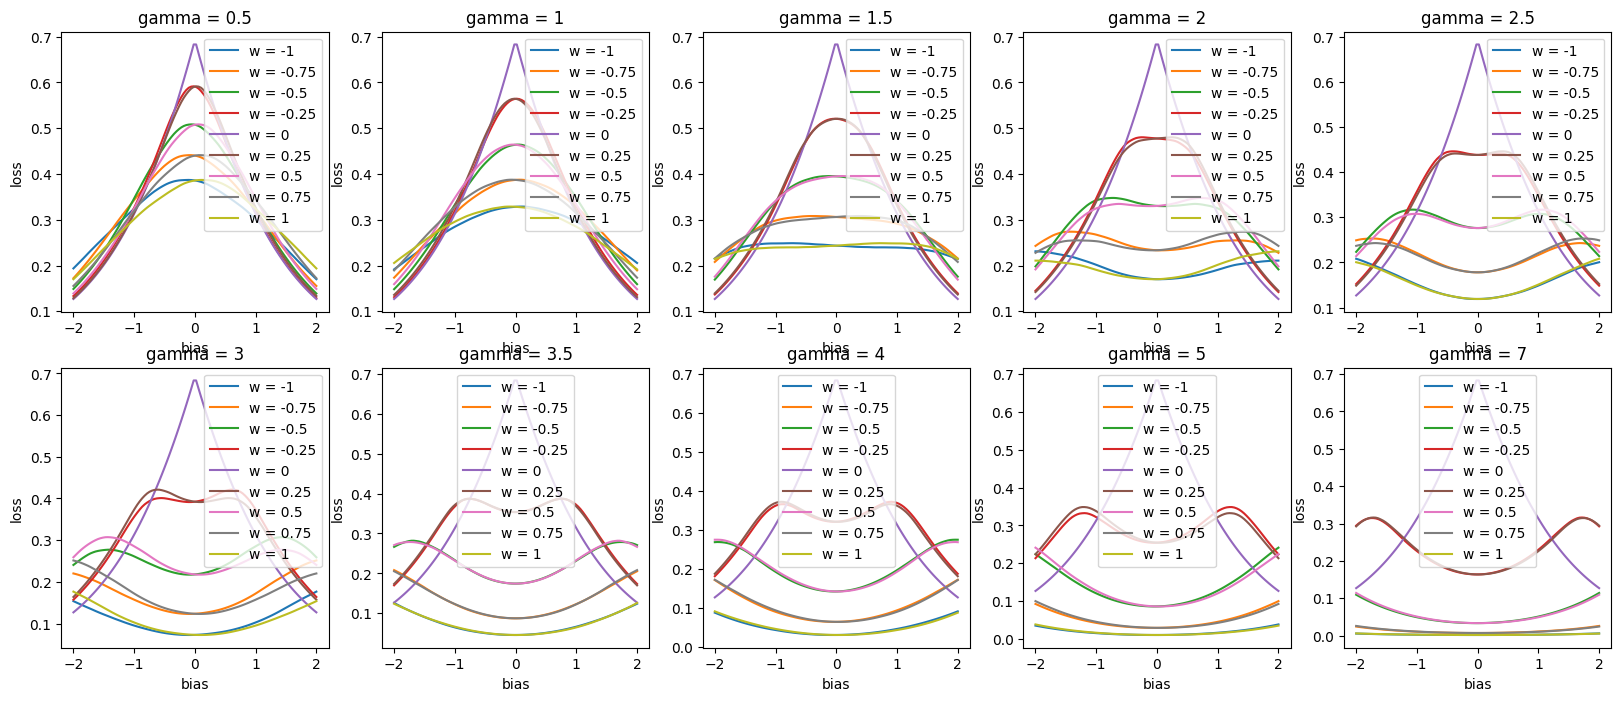

In [ ]:
f, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, gamma in enumerate([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7]):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)
    xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
    xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)
    plt.subplot(2, 5, i+1)
    for j, w in enumerate([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]):
        # plotter(xSourceTrain[ySourceTrain[:, 0] == 0], w)
        # plotter(xSourceTrain[ySourceTrain[:, 0] == 1], w)
        plotter(xSourceTrain, w)
    plt.title("gamma = {}".format(gamma))
    plt.legend()

In [ ]:
accusBeforeAdapt = collections.defaultdict(list)
accusAfterAdapt = collections.defaultdict(list)
bayesAccus = collections.defaultdict(list)

data = collections.defaultdict(dict)



torch.manual_seed(0)
reps = 1
for _ in range(reps):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)
    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    data[_]['Source'] = [xSourceTrain, ySourceTrain, xSourceTest, ySourceTest]
    data[_]['Source_Model'] = copy.deepcopy(model)
    for i in range(10):
        p = 0.5 + i/20
        xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, p)
        xTargetTest, yTargetTest = gen_data(n, d, w, gamma, p)
        data[_][p] = [xTargetTrain, yTargetTrain, xTargetTest, yTargetTest]

        bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, p)
        bayesAccus[p].append(bAccuTarget)

        temp_model = copy.deepcopy(model)
        accusBeforeAdapt[p].append(evaluate(temp_model, xTargetTest, yTargetTest))
        temp_model = adapt(temp_model, xTargetTrain, epochs=250000)
        accusAfterAdapt[p].append(evaluate(temp_model, xTargetTest, yTargetTest))
        data[_][str(p)+'_Model'] = copy.deepcopy(temp_model)
        print(" Accu after adapt for", p, "is", accusAfterAdapt[p][-1])
# for p in accusAfterAdapt:
#     accusBeforeAdapt[p] /= reps
#     accusAfterAdapt[p] /= reps
#     bayesAccus[p] /= reps

100%|██████████| 250000/250000 [02:31<00:00, 1645.49it/s]


 Accu after adapt for 0.5 is 0.6069999933242798


100%|██████████| 250000/250000 [02:27<00:00, 1689.37it/s]


 Accu after adapt for 0.55 is 0.5609999895095825


100%|██████████| 250000/250000 [02:27<00:00, 1697.87it/s]


 Accu after adapt for 0.6 is 0.6399999856948853


100%|██████████| 250000/250000 [02:28<00:00, 1684.35it/s]


 Accu after adapt for 0.65 is 0.6700000166893005


100%|██████████| 250000/250000 [02:26<00:00, 1706.59it/s]


 Accu after adapt for 0.7 is 0.7070000171661377


100%|██████████| 250000/250000 [02:25<00:00, 1715.81it/s]


 Accu after adapt for 0.75 is 0.4860000014305115


100%|██████████| 250000/250000 [02:25<00:00, 1722.67it/s]


 Accu after adapt for 0.8 is 0.7429999709129333


100%|██████████| 250000/250000 [02:24<00:00, 1725.57it/s]


 Accu after adapt for 0.85 is 0.75


100%|██████████| 250000/250000 [02:24<00:00, 1729.28it/s]


 Accu after adapt for 0.9 is 0.7570000290870667


100%|██████████| 250000/250000 [02:24<00:00, 1726.07it/s]

 Accu after adapt for 0.95 is 0.7879999876022339


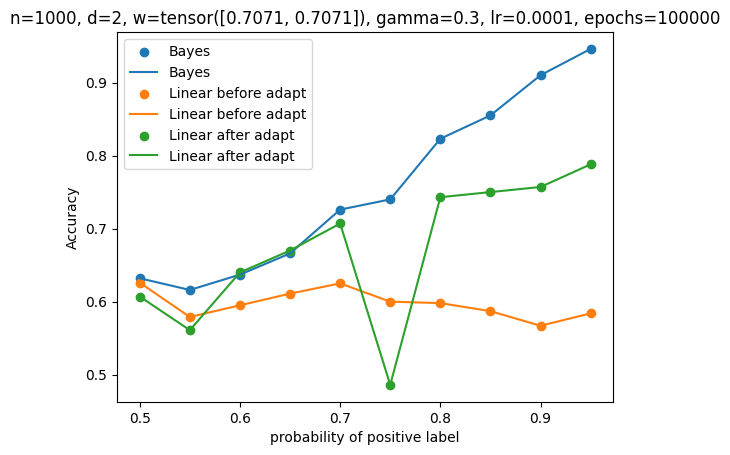

In [ ]:
plt.scatter(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.plot(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.scatter(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.plot(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.scatter(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.plot(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.xlabel("probability of positive label")
plt.title("n={}, d={}, w={}, gamma={}, lr={}, epochs={}".format(n, d, w, gamma, 0.00001, 100000))
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
# for each p count the number of points predicted as positive
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    model = data[0]['Source_Model']
    xTargetTest, yTargetTest = data[0][p][2], data[0][p][3]
    probs = torch.sigmoid(model(xTargetTest))
    preds = (probs > 0.5).float().detach()
    print("Number of positive predictions for", p, "is", preds.sum().item())

Number of positive predictions for 0.5 is 448.0
Number of positive predictions for 0.55 is 457.0
Number of positive predictions for 0.6 is 466.0
Number of positive predictions for 0.65 is 470.0
Number of positive predictions for 0.7 is 539.0
Number of positive predictions for 0.75 is 523.0
Number of positive predictions for 0.8 is 561.0
Number of positive predictions for 0.85 is 533.0
Number of positive predictions for 0.9 is 539.0
Number of positive predictions for 0.95 is 570.0


In [ ]:
# for each p count the number of points predicted as positive
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    model = data[0]['Source_Model']
    xTargetTest, yTargetTest = data[0][p][2], data[0][p][3]
    probs = torch.sigmoid(model(xTargetTest))
    preds = (probs > 0.5).float().detach()
    entropyByPredPos = F.binary_cross_entropy(probs[preds==1], preds[preds==1], reduction='none')
    entropyByPredNeg = F.binary_cross_entropy(probs[preds==0], preds[preds==0], reduction='none')
    print("Entropy for p =", p, "is", entropyByPredPos.mean().item(), entropyByPredNeg.mean().item())

Entropy for p = 0.5 is 0.5023958086967468 0.4743709862232208
Entropy for p = 0.55 is 0.49280837178230286 0.4833330810070038
Entropy for p = 0.6 is 0.48727837204933167 0.4891660809516907
Entropy for p = 0.65 is 0.5091828107833862 0.47886332869529724
Entropy for p = 0.7 is 0.4931386411190033 0.4969940483570099
Entropy for p = 0.75 is 0.4944617748260498 0.4996901750564575
Entropy for p = 0.8 is 0.4991365969181061 0.49926257133483887
Entropy for p = 0.85 is 0.4790023863315582 0.5074279308319092
Entropy for p = 0.9 is 0.4878835082054138 0.505005955696106
Entropy for p = 0.95 is 0.4738633930683136 0.5050864219665527


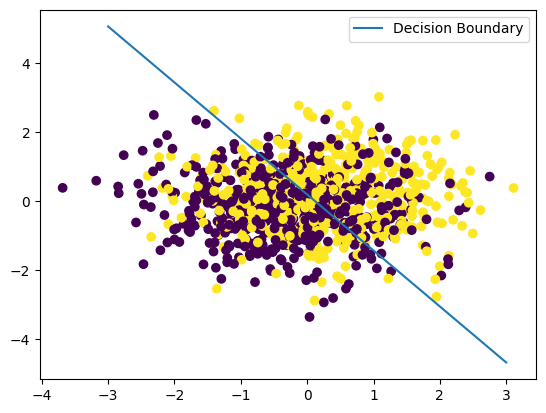

In [ ]:

# for each _ in data (reps) plot the source test data and the decision boundary

for _ in data:
    plt.scatter(data[_]['Source'][0][:, 0], data[_]['Source'][0][:, 1], c=data[_]['Source'][1], marker='o')
    plot_decision_boundary2(data[_]['Source_Model'])
    plt.show()


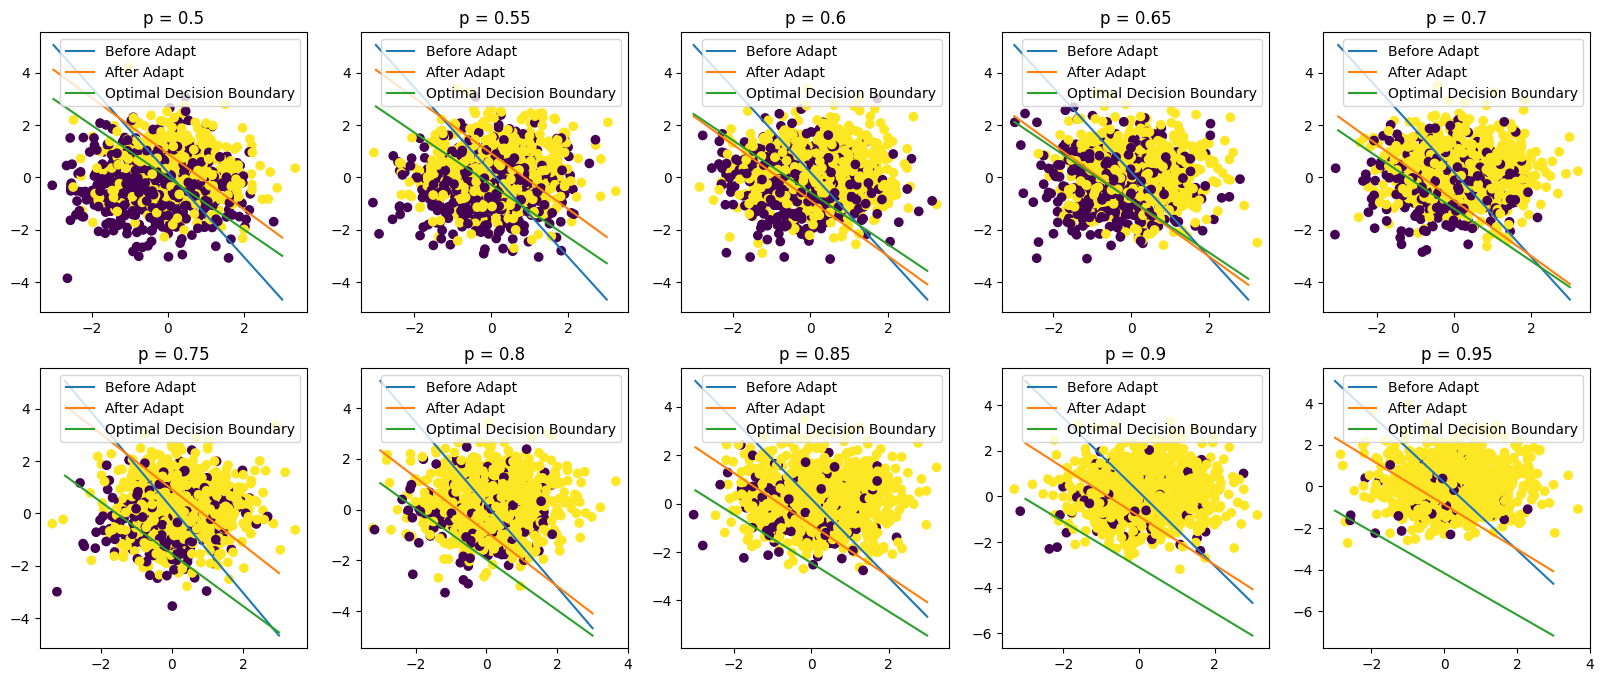

In [ ]:
# for each p in _=0 plot the target test data and the decision boundary
f, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, p in enumerate([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    plt.subplot(2, 5, i+1)
    plt.scatter(data[0][p][2][:, 0], data[0][p][2][:, 1], c=data[0][p][3], marker='o')
    plot_decision_boundary2(data[0]['Source_Model'], title='Before Adapt')
    plot_decision_boundary2(data[0][str(p)+'_Model'], title='After Adapt')
    plot_opt_decision_boundary(w, gamma, p)
    plt.title("p = {}".format(p))
plt.show()


In [ ]:
# for each _ in data (reps) print the source test accuracy and the target test accuracy before adaptation
for _ in data:
    print("Source test accuracy:", evaluate(data[_]['Model'], data[_]['Source'][2], data[_]['Source'][3]))
    for p in data[_]:
        if p != 'Source' and p != 'Model':
            print("Target test accuracy before adaptation for", p, "is", evaluate(data[_]['Model'], data[_][p][2], data[_][p][3]))
    print()

In [ ]:
p = 0.75
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)
xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)


model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
models = []
models.append(copy.deepcopy(model))
for i in range(10):
    model = adapt(model, xTargetTrain)
    models.append(copy.deepcopy(model))


100%|██████████| 100000/100000 [01:09<00:00, 1446.57it/s]


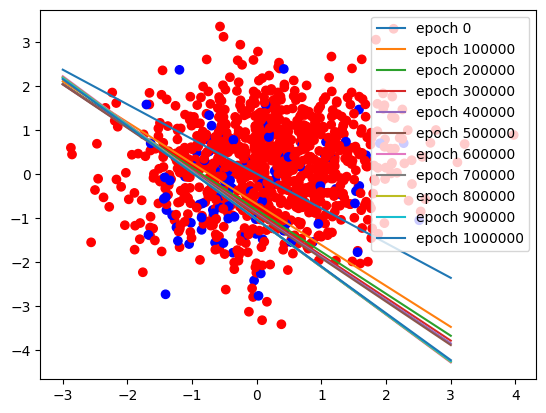

In [ ]:
plt.scatter(xTargetTest[:,0], xTargetTest[:,1], c=yTargetTest[:,0], cmap='bwr')
for i, model in enumerate(models):
    plot_decision_boundary2(model, title="epoch {}".format((i)*100000))
plt.legend()
plt.show()